# EfficientNet_b0, RAdam,lr = 0.01, image size = 224, learning rate scheduler, weight decay = 5e-5, data augmentation, dropout 0.3
### https://hipolarbear.tistory.com/19 참고

In [ ]:
# importing all the libraries we need
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import time
import random 
import pandas as pd
import torch
from torch import nn, cuda, optim
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader,random_split
from PIL import Image
import seaborn as sns
import torch.nn.functional as F

In [ ]:
!nvidia-smi

Wed Jun  8 23:14:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ./dataset
!unzip /content/drive/MyDrive/4-1/data/Bird.zip -d ./dataset

In [ ]:
# data augmentation
import random
import numpy as np
import os
import cv2
import glob
from PIL import Image
import PIL.ImageOps    

num_augmented_images = 120

file_path = '/content/dataset/train/'
folder_names = os.listdir(file_path)
total_origin_folder_num = len(folder_names)
print(total_origin_folder_num) # 폴더 400개가 맞는지 확인

for k in range(total_origin_folder_num):
  folder_name = file_path + folder_names[k]
  file_names = os.listdir(folder_name)
  total_origin_image_num = len(file_names)
  augment_cnt = 1

  for i in range(num_augmented_images):
      file_name = file_names[i]
    
      origin_image_path = folder_name + '/' + file_name
      image = Image.open(origin_image_path)

      transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1)])

      transform_image = transform(image)
      transform_image.save(folder_name + '/transform_' + str(augment_cnt) + '.jpg')

      augment_cnt += 1

  print(k+1, '번째 ', folder_name, '완료')

In [ ]:
# data augmentation 2
num_augmented_images = 100

file_path = '/content/dataset/train/'
folder_names = os.listdir(file_path)
total_origin_folder_num = len(folder_names)
print(total_origin_folder_num) # 폴더 400개가 맞는지 확인

for k in range(total_origin_folder_num):
  folder_name = file_path + folder_names[k]
  file_names = os.listdir(folder_name)
  total_origin_image_num = len(file_names)
  augment_cnt = 1

  for i in range(num_augmented_images):
      change_picture_index = random.randrange(1, total_origin_image_num-1)

      file_name = file_names[change_picture_index]
    
      origin_image_path = folder_name + '/' + file_name
      image = Image.open(origin_image_path)

      transform = transforms.Compose([transforms.RandomRotation(45),
                                      transforms.RandomPerspective(distortion_scale=0.2, p=1)])

      transform_image = transform(image)
      transform_image.save(folder_name + '/transform_x2_' + str(augment_cnt) + '.jpg')

      augment_cnt += 1

  print(k+1, '번째 ', folder_name, '완료')

In [ ]:
# Knowing the data 
# data_dir = '/kaggle/input/100-bird-species/175/'
data_dir = '/content/dataset/train'

classes = []
img_per_class = []
# for folder in os.listdir(data_dir+'consolidated'):/
for folder in os.listdir(data_dir):    
    classes.append(folder)
    img_per_class.append(len(os.listdir(f'{data_dir}/{folder}')))
num_classes = len(classes)
df = pd.DataFrame({'Classes':classes, 'Examples':img_per_class})

print('총 데이터 갯수: ', df['Examples'].sum())
df

총 데이터 갯수:  146388


,Classes,Examples
0,INDIAN BUSTARD,351
1,CLARKS NUTCRACKER,381
2,SWINHOES PHEASANT,437
3,RUBY THROATED HUMMINGBIRD,355
4,CALIFORNIA GULL,340
...,...,...
395,RED WISKERED BULBUL,343
396,BROWN THRASHER,385
397,AMERICAN GOLDFINCH,353
398,CHUCAO TAPACULO,361


Train 시 로그를 보여주기위해 선언한 Class입니다.

In [ ]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Parameter가 5M 미만이 되도록 Custom한 ResNet 코드입니다.
다른 Model을 사용하는 경우 삭제해도 무방합니다.



In [ ]:
efficientnet_b0 = models.efficientnet_b0(pretrained=False)

efficientnet_b0.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(1280, 400)
)

위에서 정의한 Model을 만들고 Parameter수를 체크한 후
5M 미만인 경우 GPU에서 정상 사용되는지 확인하는 부분입니다.

In [ ]:
# loading the model architecture
model = efficientnet_b0.cuda()

# Check number of parameters your model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params}")
if int(pytorch_total_params) > 5000000:
    print('Your model has the number of parameters more than 5 millions..')
    sys.exit()
    
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
model.to(device)
print(device)

Number of parameters: 4519948
cuda:0


In [ ]:
from torchsummary import summary

summary(model, input_size=(3,224,224))

Train Data를 불러와 Train set/Validation set으로 구분한 후
각 Data에 Augmentation 기법을 적용하는 부분입니다.

In [ ]:
# doing data augmentation 
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomRotation(45),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
val_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# splitting the data into train/validation/test sets
data = datasets.ImageFolder(data_dir)
train_size = int(len(data)*0.9)
val_size = int((len(data)-train_size))
train_data, val_data = random_split(data,[train_size,val_size])
torch.manual_seed(3334)
print(f'train size: {len(train_data)}\nval size: {len(val_data)}')

train_data.dataset.transform = train_transform
val_data.dataset.transform = val_transform
batch_size = 128
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True, num_workers=4)
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=True, num_workers=4)


train size: 131749
val size: 14639


In [ ]:
batch_iterator = iter(train_loader)
images = next(batch_iterator)

images[0].shape

torch.Size([128, 3, 224, 224])

Loss Function과 Optimizer를 선언하는 부분입니다.
다양한 Loss와 Optimizer를 통해 성능을 올려보세요!

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.RAdam(model.parameters(), lr=0.000001, weight_decay=5e-5)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=1, eta_max=0.01,  T_up=12, gamma=1)

Train 해주는 함수입니다.

In [ ]:
def fit(model,criterion,optimizer,num_epochs=10):
    print_freq = 30
    start = time.time()
    best_model = model.state_dict()
    best_acc = 0
    train_loss_over_time = []
    val_loss_over_time = []
    train_acc_over_time = []
    val_acc_over_time = []


    # each epoch has a training and validation phase
    for epoch in range(num_epochs):
        
        print("\n----- epoch: {}, lr: {} -----".format(epoch, optimizer.param_groups[0]["lr"]))
        batch_time = AverageMeter('Time', ':6.3f')
        acc = AverageMeter('Accuracy', ':.4e')
        progress = ProgressMeter(len(train_loader), batch_time, acc, prefix="Epoch: [{}]".format(epoch))

        for phase in ['train','val']:
            
            if phase == 'train':
                data_loader = train_loader
                model.train()                    # set the model to train mode
                end = time.time()

            else:
                data_loader = val_loader
                model.eval()                    # set the model to evaluate mode
                end = time.time()
            
                
            running_loss = 0.0
            running_corrects = 0.0
            
            # iterate over the data
            for i,(inputs,labels) in enumerate(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,pred = torch.max(outputs,dim=1)
                    loss = criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # calculating the loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

                epoch_acc = (running_corrects.double()/len(train_data)).cpu().numpy()
                acc.update(epoch_acc.item(), inputs.size(0))
                
                if phase == 'train':                          
                    batch_time.update(time.time() - end)
                    end = time.time()

                    if i % print_freq == 0:
                        progress.print(i)  

            if phase == 'train':

                epoch_loss = running_loss/len(train_data)
                train_loss_over_time.append(epoch_loss)
                epoch_acc = (running_corrects.double()/len(train_data)).cpu().numpy()
                train_acc_over_time.append(epoch_acc)


            else:
                epoch_loss = running_loss/len(val_data)
                val_loss_over_time.append(epoch_loss)
                epoch_acc = (running_corrects.double()/len(val_data)).cpu().numpy()
                val_acc_over_time.append(epoch_acc)
          

            print(f'{phase} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f}')
            
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), '/content/drive/MyDrive/model_best_pleaseplease.pt')
            
            torch.save(model.state_dict(),'model_latest.pt')
            
        scheduler.step() #####

        print('-'*60)
    print('\n') 
    elapsed_time = time.time() - start
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    print(f'best accuracy: {best_acc:.3f}')


    # load best model weights
    model.load_state_dict(best_model)
    loss = {'train':train_loss_over_time, 'val':val_loss_over_time}
    acc = {'train':train_acc_over_time, 'val':val_acc_over_time}

    return model,loss, acc

Train 함수를 통해 Epoch수만큼 학습하는 부분입니다.

In [ ]:
# training the model
# trained for 5 epochs then for 3 epochs then 2
epochs = 50
history, loss, acc = fit(model, criterion, optimizer, num_epochs = epochs)


----- epoch: 0, lr: 1e-06 -----
Epoch: [0][   0/1030]	Time  1.812 ( 1.812)	Accuracy 0.0000e+00 (0.0000e+00)
Epoch: [0][  30/1030]	Time  0.483 ( 0.523)	Accuracy 4.5541e-05 (3.0850e-05)
Epoch: [0][  60/1030]	Time  0.479 ( 0.502)	Accuracy 1.4421e-04 (6.9307e-05)
Epoch: [0][  90/1030]	Time  0.485 ( 0.495)	Accuracy 2.3530e-04 (1.0359e-04)
Epoch: [0][ 120/1030]	Time  0.480 ( 0.491)	Accuracy 3.1879e-04 (1.4628e-04)
Epoch: [0][ 150/1030]	Time  0.479 ( 0.489)	Accuracy 3.9469e-04 (1.8659e-04)
Epoch: [0][ 180/1030]	Time  0.479 ( 0.488)	Accuracy 4.8577e-04 (2.3005e-04)
Epoch: [0][ 210/1030]	Time  0.480 ( 0.487)	Accuracy 5.6926e-04 (2.7062e-04)
Epoch: [0][ 240/1030]	Time  0.479 ( 0.486)	Accuracy 6.1481e-04 (3.1044e-04)
Epoch: [0][ 270/1030]	Time  0.479 ( 0.486)	Accuracy 6.9071e-04 (3.4918e-04)
Epoch: [0][ 300/1030]	Time  0.479 ( 0.485)	Accuracy 7.4384e-04 (3.8637e-04)
Epoch: [0][ 330/1030]	Time  0.479 ( 0.485)	Accuracy 7.9697e-04 (4.2207e-04)
Epoch: [0][ 360/1030]	Time  0.479 ( 0.485)	Accuracy 8.7

Train결과로 나온 정확도와 Loss가 몇 Epoch에서 최적인지 볼 수 있도록 구성해놓은 Plotting 부분입니다.

Text(0.5, 1.0, 'Accuracy')

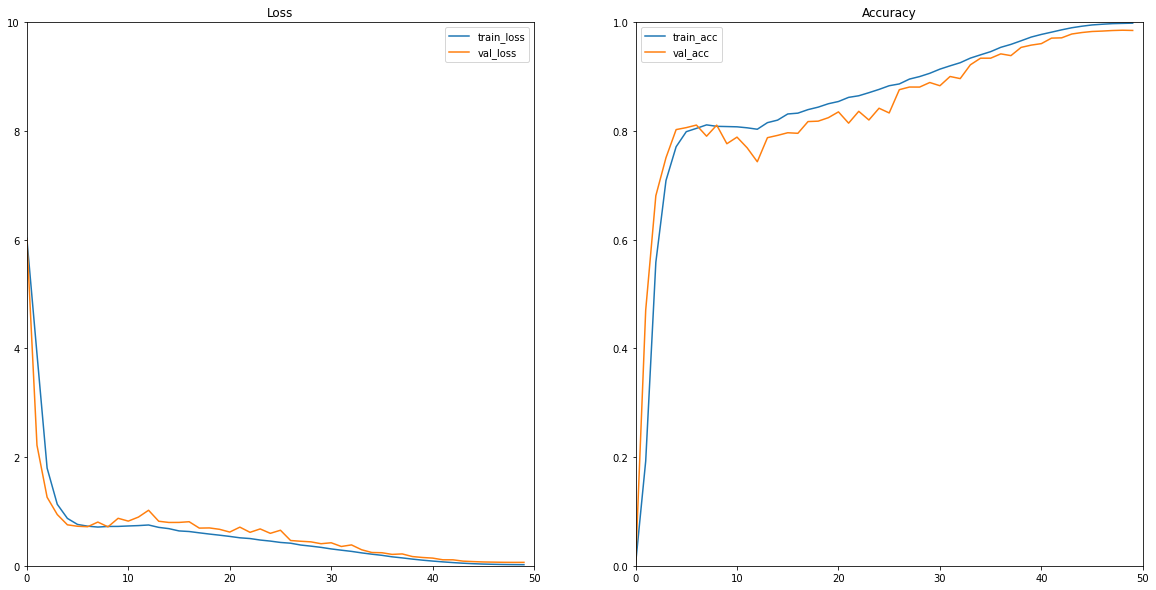

In [ ]:
# plotting the loss and accuracy curve for each phase
train_loss = loss['train']
val_loss = loss['val']
train_acc = acc['train']
val_acc = acc['val']

epochs_range = range(epochs)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.ylim(0,10)
plt.xlim(0,50)
plt.plot(epochs_range, train_loss, label='train_loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend(loc=0)
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_acc ,label='train_acc')
plt.plot(epochs_range, val_acc, label='val_acc')
plt.legend(loc=0)
plt.ylim(0,1)
plt.xlim(0,50)
plt.title('Accuracy')

Test Dataset을 불러오는 부분입니다.

In [ ]:
seed = 0
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

torch.manual_seed(3334)
test_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# splitting the data into train/validation/test sets
test_data_dir = '/content/dataset/test'
_data = datasets.ImageFolder(test_data_dir)
test1_size = int(len(_data)*1)
test2_size = int((len(_data)-test1_size))
test_data, test2_data = torch.utils.data.random_split(_data,[test1_size, test2_size])
torch.manual_seed(3334)

print(f'test size: {len(test_data)}')

test_data.dataset.transform = test_transform
batch_size = 128
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)
print(test_loader)

test size: 2000


앞에서 훈련 시킨 Model중 가장 높은 정확도를 가진 모델을 불러와 Test Dataset에 대한 결과를 만들어주는 부분으로 이 코드는 변경하지 않아도 됩니다.

In [ ]:
import itertools
# testing how good the model is
def evaluate(model,criterion):
    model.eval()       # setting the model to evaluate mode
    preds = []
    Category = []
    corrects = 0 #####

    test_model = efficientnet_b0.cuda()
    #저장경로는 변경하셔도 됩니다.
    test_model.load_state_dict(torch.load('/content/drive/MyDrive/model_best_pleaseplease.pt'))

    for inputs, label_ in test_loader:
        
        inputs = inputs.to(device)
        labels = label_.to(device)
        # predicting
        with torch.no_grad():

            outputs = test_model(inputs)
            _,pred = torch.max(outputs,dim=1)
            preds.append(pred)

            corrects += torch.sum(pred == labels.data) #####

    acc = (corrects.double()/2000).cpu().numpy() #####

    category = [t.cpu().numpy() for t in preds]
    
    t_category = list(itertools.chain(*category))
   
    Id = list(range(0, len(t_category)))

    prediction = {
      'Id': Id,
      'Category': t_category 
    }

    prediction_df = pd.DataFrame(prediction, columns=['Id','Category'])
    #저장경로는 변경하셔도 됩니다.
    prediction_df.to_csv('/content/drive/MyDrive/model_best_pleaseplease.csv', index=False)
    print(acc)
    print('Done!!')
        
    return preds

# testing the model
predictions = evaluate(model, criterion)

0.99
Done!!
